# Homework 2: Due 2018-12-03 (Monday)

* Implement an explicit Runge-Kutta integrator that takes an initial time step $h_0$ and an error tolerance $\epsilon$.
* You can use the Bogacki-Shampine method or any other method with an embedded error estimate.
* A step should be rejected if the local truncation error exceeds the tolerance.
* Test your method on the nonlinear equation
$$ \begin{bmatrix} \dot u_0 \\ \dot u_1 \end{bmatrix} = \begin{bmatrix} u_1 \\ k (1-u_0^2) u_1 - u_0 \end{bmatrix} $$
for $k=2$, $k=5$, and $k=20$.
* Make a work-precision diagram for your adaptive method and for constant step sizes.
* State your conclusions or ideas (in a README, or Jupyter notebook) about appropriate (efficient, accurate, reliable) methods for this type of problem.

In [66]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot
pyplot.style.use('ggplot')

def rk_butcher_bs3():
    A = np.array([[0, 0, 0, 0],
                     [1/2, 0, 0, 0],
                     [0, 3/4, 0, 0],
                     [2/9, 1/3, 4/9, 0]])
    b = np.array([[2/9, 1/3, 4/9, 0],
                     [7/24, 1/4, 1/3, 1/8]])
    p = 3
    return A, b, p

def rk_butcher_4():
    A = np.array([[0,0,0,0],[.5,0,0,0],[0,.5,0,0],[0,0,1,0]])
    b = np.array([1/6, 1/3, 1/3, 1/6])
    p = 2
    return A, b, p

def ode_rkexplicit(f, u0, butcher=rk_butcher_bs3(), tfinal=1, h=.1):#briefly modified from in-class notebook
    A, b, _ = butcher
    b = b[0,:]
    c = np.sum(A, axis=1)
    s = len(c)
    u = u0.copy()
    t = 0
    hist = [(t,u0)]
    while t < tfinal:
        if tfinal - t < 1.01*h:
            h = tfinal - t
            tnext = tfinal
        else:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = np.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        u += h * fY.dot(b)
        t = tnext
        hist.append((t, u.copy()))
    return hist

def ode_rkadaptive(f, u0, butcher=rk_butcher_bs3(), epsilon = 1e-8, tfinal=1, h=.1):
    A, b, p = butcher
    c = np.sum(A, axis=1) 
    s = len(c)  
    u = u0.copy() 
    t = 0 
    timestep_hist = [(t,h)] 
    hist = [(t,u0)] 
    redo_hist = [] 
    error_hist = [] 
    redoStep = 0 
    while t < tfinal: #loop over time
        if tfinal - t < 1.01*h: 
            h = tfinal - t
            tnext = tfinal
        elif  not redoStep:
            tnext = t + h
        h = min(h, tfinal - t)
        fY = np.zeros((len(u0), s))
        for i in range(s):
            Yi = u.copy()
            for j in range(i):
                Yi += h * A[i,j] * fY[:,j]
            fY[:,i] = f(t + h*c[i], Yi)
        eloc = max(h * fY.dot(b[0,:]-b[1,:])) #take the max error of the 2 solutions
        error_hist.append(eloc)
        if eloc > epsilon:
            h = 0.9 * h * (epsilon / eloc)**(1/p)
            redoStep = 1;
        else:
            u += h * fY.dot(b[0,:])
            t = tnext
            redoStep = 0
            timestep_hist.append((t, h))
            hist.append((t, u.copy()))
        redo_hist.append(redoStep)
        
    return hist, timestep_hist, error_hist, redo_hist



408514
1146015
6619596


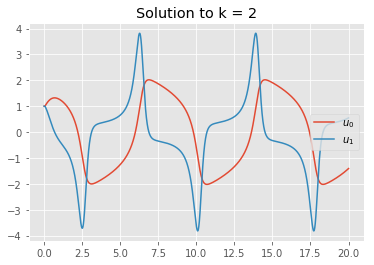

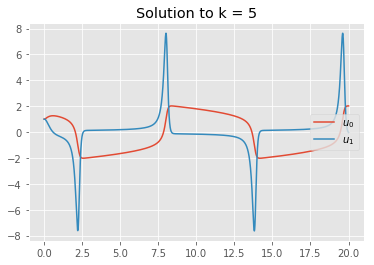

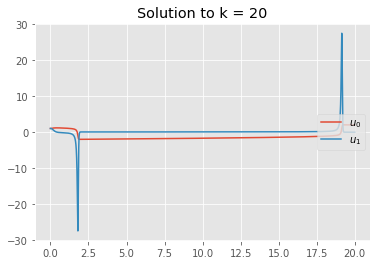

In [44]:
class test_function:
    def __init__(self, k=5):
        self.k = k
    def f(self,t, u):
        return [ u[1], self.k*(1-u[0]**2)*u[1]-u[0] ]
    
tests = [test_function(2), test_function(5), test_function(20)]

u0 = np.array([1.0, 1])

for test in tests:
    hist, h_hist, e_hist,redo_hist = ode_rkadaptive(test.f, u0, epsilon = 1e-12,h = .05,tfinal = 20)
    t_list = [t for t,u in hist]
    print(len(redo_hist))
    pyplot.figure()
    pyplot.plot(t_list, [u[0] for t,u in hist], label = '$u_0$')
    pyplot.plot(t_list, [u[1] for t,u in hist], label = '$u_1$')
    pyplot.legend(loc='right')
    pyplot.title('Solution to k = %d'%test.k)

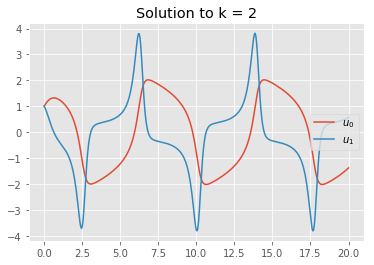

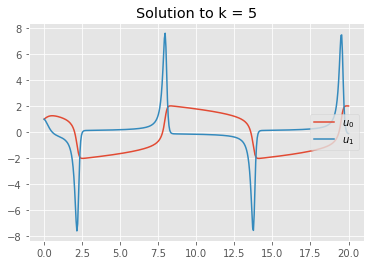

In [42]:
for test in tests[:2]:
    hist = ode_rkexplicit(test.f, u0, h = .05,tfinal = 20)
    t_list = [t for t,u in hist]
    pyplot.figure()
    pyplot.plot(t_list, [u[0] for t,u in hist], label = '$u_0$')
    pyplot.plot(t_list, [u[1] for t,u in hist], label = '$u_1$')
    pyplot.legend(loc='right')
    pyplot.title('Solution to k = %d'%test.k)

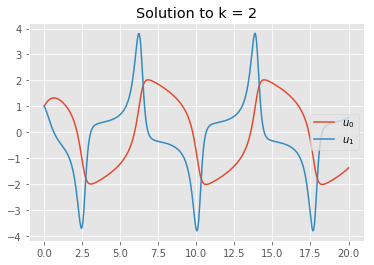

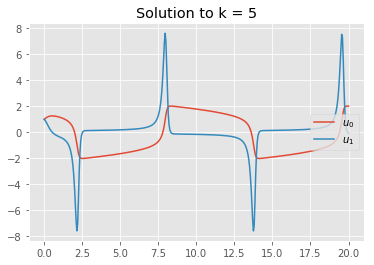

In [55]:
for test in tests[:2]:
    hist = ode_rkexplicit(test.f, u0, butcher=rk_butcher_4(), h = .05,tfinal = 20)
    t_list = [t for t,u in hist]
    pyplot.figure()
    pyplot.plot(t_list, [u[0] for t,u in hist], label = '$u_0$')
    pyplot.plot(t_list, [u[1] for t,u in hist], label = '$u_1$')
    pyplot.legend(loc='right')
    pyplot.title('Solution to k = %d'%test.k)

In [54]:
#This cell is completely copied from the in class notebooks
def expm(A):
    """Compute the matrix exponential"""
    L, X = np.linalg.eig(A)
    return X.dot(np.diag(np.exp(L))).dot(np.linalg.inv(X))

class linear:
    def __init__(self, A):
        self.A = A.copy()
    def f(self, t, u):
        return self.A.dot(u)
    def u(self, t, u0):
        t = np.array(t, ndmin=1)
        return [np.real(expm(self.A*s).dot(u0)) for s in t]

Text(0.5,1,'Linear problem with explicit method')

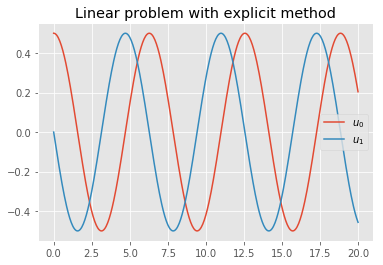

In [70]:
test = linear(np.array([[0, 1],[-1, 0]]))
u0 = np.array([.5, 0])
hist = ode_rkexplicit(test.f, u0, h = .05,tfinal = 20)
t_list = [t for t,u in hist]
pyplot.figure()
pyplot.plot(t_list, [u[0] for t,u in hist], label = '$u_0$')
pyplot.plot(t_list, [u[1] for t,u in hist], label = '$u_1$')
pyplot.legend(loc='right')
pyplot.title('Linear problem with explicit method')


Text(0.5,1,'Linear problem with adaptive method')

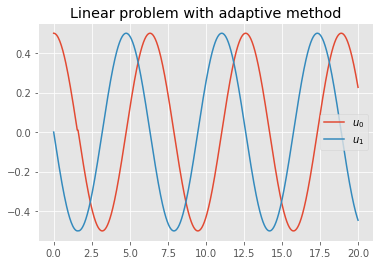

In [72]:
hist, h_hist, e_hist,redo_hist = ode_rkadaptive(test.f, u0, epsilon = 1e-12,h = .05,tfinal = 20)
t_list = [t for t,u in hist]
pyplot.figure()
pyplot.plot(t_list, [u[0] for t,u in hist], label = '$u_0$')
pyplot.plot(t_list, [u[1] for t,u in hist], label = '$u_1$')
pyplot.legend(loc='right')
pyplot.title('Linear problem with adaptive method')

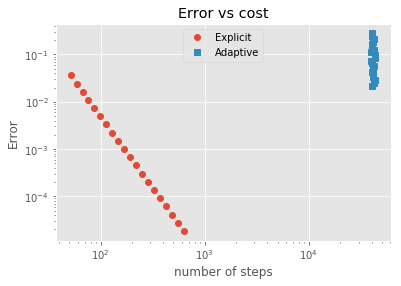

In [68]:
import inspect

def mms_error(h, rk_butcher,method):
    num_steps = 0
    if len(inspect.signature(method).parameters) > 5:
        hist, timestep_hist, error_hist, redo_hist = method(test.f, u0, rk_butcher(), tfinal=20, h=h, epsilon = 1e-12)
        num_steps = len(redo_hist)
    else:
        hist = method(test.f, u0, rk_butcher(), tfinal=20, h=h)
        num_steps = len(hist)
    
    times = [t for t,u in hist]
    u = np.array([u for t,u in hist])
    return np.linalg.norm(u - test.u(times, u0), np.inf), num_steps

hs = np.logspace(-1.5, -.4, 20)
error_explicit = []
error_adaptive = []
num_steps_explicit = []
num_steps_adaptive = []
for h in hs:
    e_explicit, ns_explicit = mms_error(h, rk_butcher_bs3, ode_rkexplicit)
    error_explicit.append(e_explicit)
    num_steps_explicit.append(ns_explicit)
    e_adaptive, ns_adaptive = mms_error(h, rk_butcher_bs3, ode_rkadaptive)
    error_adaptive.append(e_adaptive)
    num_steps_adaptive.append(ns_adaptive)
    
    
pyplot.loglog(num_steps_explicit, error_explicit, 'o', label='Explicit')
pyplot.loglog(num_steps_adaptive, error_adaptive, 's', label='Adaptive')
pyplot.title('Error vs cost')
pyplot.ylabel('Error')
pyplot.xlabel('number of steps')
pyplot.legend(loc='upper center');
    

Since we are using the same Butcher table in both methods, we will have the same number of function evaluations per timestep. The difference is the adaptive   We see that the adaptive method uses a lot more